In [3]:
# y finance client to grab the data 
import yfinance as yf
# matplotlib to plot stuff
import matplotlib.pyplot as plt
# for dataframe creation
import pandas as pd
# for arrays 
import numpy as np
import math
# for creating the lstm model
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
# parameters for the lstm model
from keras.layers import LSTM, Dense, Dropout
import seaborn as sns
#sns.set_style('whitegrid')
#plt.style.use("fivethirtyeight")
from datetime import datetime
# for normalising dataset 
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline
# For reading stock data from yahoo
from pandas_datareader.data import DataReader
import datetime as dt
from tensorflow.keras.optimizers import Adam
import sys
np.set_printoptions(threshold=sys.maxsize)
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler

In [5]:
big_6 = ["NEE", "DUK", "SO","D","NGG","AEP"]

# Get data I want to use 

## Stocks

In [6]:
def get_stock_data(stock, date):
    # reading data from yahoo
    df = DataReader(stock, data_source ='yahoo', start = date, end = datetime.now())
    
    return df

def get_stock_data_2020(stock):
    # reading data from yahoo
    df = DataReader(stock, data_source ='yahoo', start = "2020-01-01", end = datetime.now())
    
    return df

In [4]:
# gets the mean average price of as many stocks as you wish
def plot_mean_average_close_price(*stock):
    mean_list = []
    for stocks in stock:
        df = yf.download(stocks, "2020-01-01")
        mean_list.append(df["Close"].mean())
    plt.bar(stock, mean_list)
    plt.title(f"Average close price of the {len(stock)} energy companies from 2020")
    plt.ylabel('Price($)')
    for i in range(len(stock)):
        plt.text(i,mean_list[i],round(mean_list[i]),ha = "center")
    plt.show()

[*********************100%***********************]  1 of 1 completed


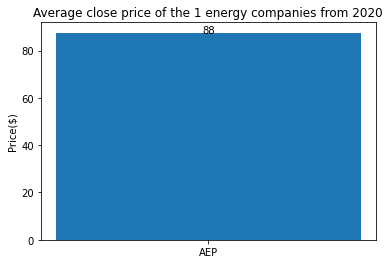

In [6]:
plot_mean_average_close_price("AEP")

In [2]:
plot_mean_average_close_price("NEE","NEG")

NameError: name 'yf' is not defined

In [26]:
def stocks_in_one_dataset(stock,*args):
    date = str(input("Enter start date: "))
    df = yf.download(stock, date)
    df["Ticker"] = stock 
    if len(args)>= 1:
        for arg in args:
            df1 = yf.download(arg, date)
            df1["Ticker"] = arg
            df = pd.concat([df, df1])
    print(df.tail(5))
    return df

In [9]:
def plot_stocks_close(*stock):
    date = str(input("Enter start date in y-m-d format: "))
    group = []
    #grab data
    for stocks in stock:
        data = yf.download(stock, date)
        group.append(data)
        
    # attach ticker
    plt.figure(figsize=(16, 8))
    for company, stockname in zip(group,stock):
        company["Close"].plot(label = stockname)
            
    plt.title(f"Close price of {len(stock)} energy companies from 2020", fontsize = 20)
    plt.ylabel("Close Price($)", fontsize = 18)
    plt.xlabel("DATE",fontsize = 18)
    plt.legend()
    plt.show()

def plot_stocks_close2(stock,date):
    group = []
    #grab data
    data = yf.download(stock, date)
    group.append(data)
        
    # attach ticker
    plt.figure(figsize=(16, 8))
    data["Close"].plot(label = stock)
            
    plt.title(f"Close price of {stock} from {date}", fontsize = 20)
    plt.ylabel("Close Price($)", fontsize = 18)
    plt.xlabel("DATE",fontsize = 18)
    plt.legend()
    plt.show()

In [10]:
def retrieve_stock_summary():
    stock = str(input("Enter ticker label of the stock you wish to summarise: "))
    df = get_stock_data(stock)
    df = df.describe()
    df["Stock"] = stock
    #print(df)
    return df

### **LSTM adapted from** :

https://www.kaggle.com/code/faressayah/stock-market-analysis-prediction-using-lstm

In [8]:
def lstm_standalone_stock(stock, date):
    df = DataReader(stock, data_source='yahoo', start=date, end=datetime.now())
    # Show data
    plot_stocks_close2(stock,date=date)
    # Create a new dataframe with only the 'Close column 
    data = df.filter(['Close'])
    # Convert the dataframe to a numpy array
    dataset = data.values
    # Get the number of rows to train the model on
    training_data_len = int(np.ceil( len(dataset) * .8))
    # Scale the data
    scaler = MinMaxScaler(feature_range=(0,1))
    scaled_data = scaler.fit_transform(dataset)
    # Create the training data set 
    # Create the scaled training data set
    train_data = scaled_data[0:int(training_data_len), :]
    # Split the data into x_train and y_train data sets
    x_train = []
    y_train = []
    for i in range(60, len(train_data)):
        x_train.append(train_data[i-60:i, 0])
        y_train.append(train_data[i, 0])
    # Convert the x_train and y_train to numpy arrays 
    x_train, y_train = np.array(x_train), np.array(y_train)
    # Reshape the data
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    # Build the LSTM model
    model = Sequential()
    model.add(LSTM(128, return_sequences = True, input_shape = (x_train.shape[1], 1)))
    model.add(LSTM(64, return_sequences = False))
    model.add(Dense(25))
    model.add(Dense(1))
    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')
    # Train the model
    print(model.summary())
    model.fit(x_train, y_train, batch_size=1, epochs=1)

    # Create the testing data set
    # Create a new array containing scaled values from index 512 to 639
    test_data = scaled_data[training_data_len - 60: , :]
    # Create the data sets x_test and y_test
    x_test = []
    y_test = dataset[training_data_len:, :]
    for i in range(60, len(test_data)):
        x_test.append(test_data[i-60:i, 0])
    # Convert the data to a numpy array
    x_test = np.array(x_test)
    # Reshape the data
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))
    # Get the models predicted price values 
    predictions = model.predict(x_test)
    predictions = scaler.inverse_transform(predictions)
    # Get the root mean squared error (RMSE)
    rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
    # Plot the data
    train = data[:training_data_len]
    valid = data[training_data_len:]
    valid['Predictions'] = predictions
    # Visualize the data
    plt.figure(figsize=(16,6))
    plt.title(f'{stock} Model')
    plt.xlabel('Date', fontsize=18)
    plt.ylabel('Close Price USD ($)', fontsize=18)
    plt.plot(train['Close'])
    plt.plot(valid[['Close', 'Predictions']])
    plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
    plt.show()
    print(f"the rmse for {stock} is {rmse}")

[*********************100%***********************]  1 of 1 completed


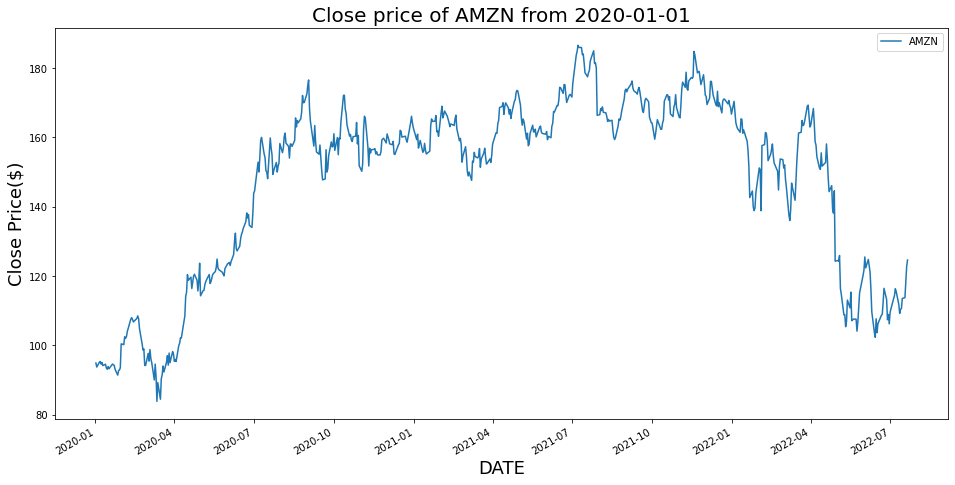

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_24 (LSTM)              (None, 60, 128)           66560     
                                                                 
 lstm_25 (LSTM)              (None, 64)                49408     
                                                                 
 dense_16 (Dense)            (None, 25)                1625      
                                                                 
 dense_17 (Dense)            (None, 1)                 26        
                                                                 
Total params: 117,619
Trainable params: 117,619
Non-trainable params: 0
_________________________________________________________________
None
455/455 [==============================] - 18s 33ms/step - loss: 0.0097


/var/folders/yr/smlj2v7135v6h7n15bgx873h0000gn/T/ipykernel_94674/3540755847.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


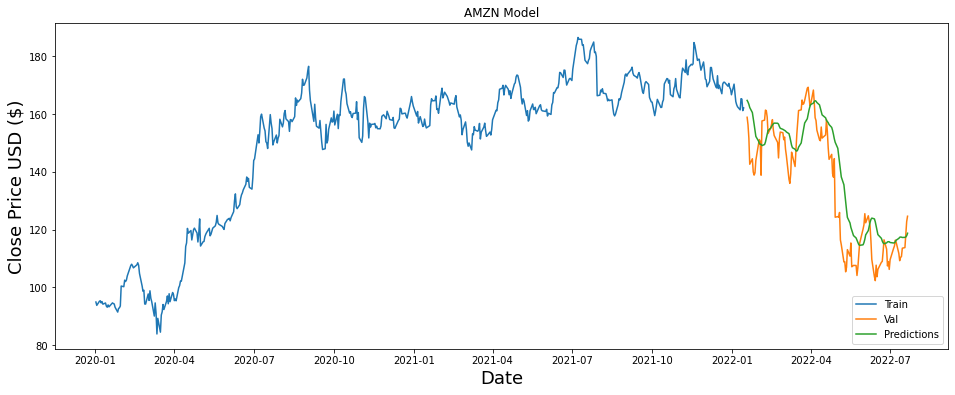

the rmse for AMZN is 10.74255663097265


In [86]:
lstm_standalone_stock("AMZN", "2020-01-01")

## Oil

In [56]:
# get oil prices
def oil_prices():
    date = str(input("Enter start date in y-m-d format: "))
    oil_prices = pd.read_csv("oil_price_brent.csv", skiprows = 4)
    #oil_prices = oil_prices.loc[:639]
    oil_prices["Day"] = pd.to_datetime(oil_prices["Day"], format = "%m/%d/%Y")
    oil_prices.columns = ["Date", "oil_price_per_barrel"]
    oil_prices = oil_prices.set_index("Date")
    oil_prices = oil_prices.loc[date:]
    return oil_prices

def oil_prices_2020():
    oil_prices = pd.read_csv("oil_price_brent.csv", skiprows = 4)
    #oil_prices = oil_prices.loc[:639]
    oil_prices["Day"] = pd.to_datetime(oil_prices["Day"], format = "%m/%d/%Y")
    oil_prices.columns = ["Date", "oil_price_per_barrel"]
    oil_prices = oil_prices.set_index("Date")
    oil_prices = oil_prices.loc["2020-01-01":]
    return oil_prices

In [11]:
def oil_price_graph():
    df = oil_prices()
    #plotting graph 
    plt.figure(figsize = (16,8))
    df["oil_price_per_barrel"].plot()
    plt.title("Price of oil from start date")
    plt.ylabel("Close Price($)", fontsize = 18)
    plt.show()

# Consumer price index

In [37]:
# get cpi data
def get_CPI():
    date = str(input("Please enter start date, cannot be earlier than 01-02-1988 (format Y-M-D): "))
    #uk
    uk_cpi = pd.read_csv("uk_cpi_energy.csv",skiprows = 7)
    uk_cpi.columns = ["Date", "CPI_percentage"]
    uk_cpi["Date"] = pd.to_datetime(uk_cpi["Date"], format = "%Y %b")
    uk_cpi = uk_cpi.set_index("Date").resample('D').ffill()
    uk_cpi = uk_cpi.loc[date:]
    #us
    us_cpi = pd.read_excel("us_energy_cpi.xlsx",skiprows = 11)
    us_cpi = us_cpi[["Year", "Value"]]
    us_cpi.columns = ["Date", "CPI_rate"]
    us_cpi["Date"] = pd.to_datetime(us_cpi["Date"], format = "%Y-%M-%D")
    us_cpi = us_cpi.set_index("Date").resample('D').ffill()
    #both
    us_and_uk_cpi = us_cpi.merge(uk_cpi, on = 'Date', how = 'inner')
    us_and_uk_cpi.columns = ["CPI_rate_US", "CPI_rate_UK"]

    return us_and_uk_cpi

In [39]:
get_CPI()

Please enter start date, cannot be earlier than 01-02-1988 (format Y-M-D): 2015-01-01


,CPI_rate_US,CPI_rate_UK
Date,,
2015-01-01,-8.2,-0.5
2015-01-02,-8.2,-0.5
2015-01-03,-8.2,-0.5
2015-01-04,-8.2,-0.5
2015-01-05,-8.2,-0.5
...,...,...
2022-05-28,6.1,0.3
2022-05-29,6.1,0.3
2022-05-30,6.1,0.3


In [42]:
def plot_CPI():
    plt.figure(figsize = (16,8))
    df = get_CPI()
    df["CPI_rate_US"].plot()
    df["CPI_rate_UK"].plot()
    plt.title("Consumer_price_index")
    plt.show()

Please enter start date, cannot be earlier than 01-02-1988 (format Y-M-D): 1999-09-28


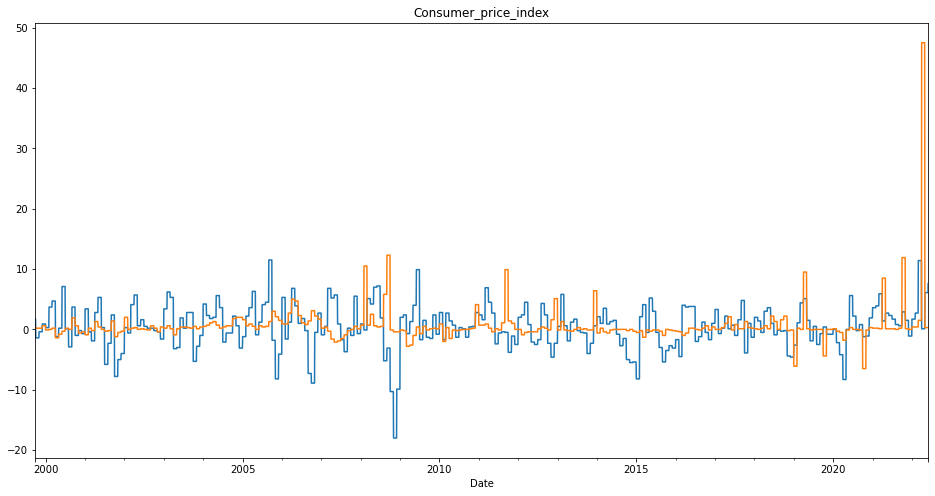

In [43]:
plot_CPI()

# Combined dataset

In [61]:
# combine dataset
def combined_stock_dataset(stock):
    df1 = oil_prices()
    #date = str(input("Please enter start date, cannot be earlier than 01-02-1988 (format Y-M-D): "))
    df = get_stock_data(stock)
    # Create a new dataframe with only the 'Close column 
    data = df.filter(['Close'])
    data.columns = [f"Close_price_{stock}"]
    data = df1.merge(data.filter([f"Close_price_{stock}"]), on = 'Date', how = 'left')
    
    us_and_uk_cpi = get_CPI()
    
    data = data.merge(us_and_uk_cpi, on = "Date", how = "left")
    data = data.dropna()
    
    
    return data

In [62]:
combined_stock_dataset("AAPL")

Enter start date in y-m-d format: 2000-01-01


/var/folders/yr/smlj2v7135v6h7n15bgx873h0000gn/T/ipykernel_2705/180016135.py:9: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  oil_prices = oil_prices.loc[date:]


Enter stock start date (y-m-d format): 2000-01-01
Please enter start date, cannot be earlier than 01-02-1988 (format Y-M-D): 2000-01-01


,oil_price_per_barrel,Close_price_AAPL,CPI_rate_US,CPI_rate_UK
Date,,,,
2022-06-01,122.20,148.710007,7.6,0.3
2022-05-31,125.53,148.839996,6.1,0.3
2022-05-27,121.19,149.639999,6.1,0.3
2022-05-26,119.81,143.779999,6.1,0.3
2022-05-25,116.41,140.520004,6.1,0.3
...,...,...,...,...
2000-01-10,22.77,0.872768,0.3,-0.1
2000-01-07,23.35,0.888393,0.3,-0.1
2000-01-06,23.55,0.848214,0.3,-0.1


In [17]:
def lstm_combined_dataset(stock):
    df = combined_stock_dataset(stock)
    train_dates = df.index.to_series()
    # columns I want to use for this
    cols = list(df)[0:3]
    # all data for training
    df_for_training = df[cols].astype(float)
    
    # normalise dataset
    scaler = StandardScaler()
    scaler = scaler.fit(df_for_training)
    df_for_training_scaled = scaler.transform(df_for_training)
    
    # For LSTM we need to reshape input into n_sample, n timesteps and n features
    
    x_train = []
    y_train = []
    
    n_future = 1
    n_past = 14
    
    for i in range(n_past, len(df_for_training_scaled) - n_future +1):
        x_train.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
        y_train.append(df_for_training_scaled[i + n_future - 1:i + n_future, 0])
        
    x_train, y_train = np.array(x_train), np.array(y_train)

    print(f'x_train shape == {y_train.shape}')
    print(f'y_train shape == {x_train.shape}')
    
    model = Sequential()
    model.add(LSTM(64, activation='relu', input_shape=(x_train.shape[1], x_train.shape[2]), return_sequences=True))
    model.add(LSTM(32, activation='relu', return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(y_train.shape[1]))
    
    model.compile(optimizer='adam', loss='mse')
    print(model.summary())
    
    # fit the model
    history = model.fit(x_train, y_train, epochs=5, batch_size=16, validation_split=0.1, verbose=1)
    
    plt.plot(history.history['loss'], label ='Training loss')
    plt.plot(history.history['val_loss'], label ='Validation loss')
    plt.legend()
    plt.show()
    
    n_past = -16
    n_days_for_prediction= 15  #let us predict past 15 days
    
    predict_period_dates = pd.date_range(list(train_dates)[-n_past], periods=n_days_for_prediction).tolist()
    print(predict_period_dates)
    
    #Make prediction
    prediction = model.predict(x_train[-n_days_for_prediction:]) #shape = (n, 1) where n is the n_days_for_prediction
    
    #Perform inverse transformation to rescale back to original range
    #Since we used 5 variables for transform, the inverse expects same dimensions
    #Therefore, let us copy our values 5 times and discard them after inverse transform
    prediction_copies = np.repeat(prediction, df_for_training.shape[1], axis=-1)
    y_pred_future = scaler.inverse_transform(prediction_copies)[:,0]
    
    
    # Convert timestamp to date
    forecast_dates = []
    for time_i in predict_period_dates:
        forecast_dates.append(time_i.date())
    
    df_forecast = pd.DataFrame({'Date':np.array(forecast_dates), f"stock_price_{stock}":y_pred_future})
    df_forecast['Date'] = pd.to_datetime(df_forecast['Date'], format = "%Y-%m-%d")
    
    original = df[f'Close_price_{stock}'].loc["2022-01-01":]
    
    plt.plot(original)
    plt.plot(df_forecast['Date'], df_forecast[f"stock_price_{stock}"])
    
    return df_forecast


### **LSTM adapted from** :

https://github.com/bnsreenu/python_for_microscopists/blob/master/181_multivariate_timeseries_LSTM_GE.py

/var/folders/yr/smlj2v7135v6h7n15bgx873h0000gn/T/ipykernel_94674/180016135.py:18: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  oil_prices = oil_prices.loc["2020-01-01":]


x_train shape == (585, 1)
y_train shape == (585, 14, 3)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 14, 64)            17408     
                                                                 
 lstm_3 (LSTM)               (None, 32)                12416     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 29,857
Trainable params: 29,857
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/5
33/33 [==============================] - 4s 31ms/step - loss: 0.3775 - val_loss: 0.1268
Epoch 2/5
33/33 [======

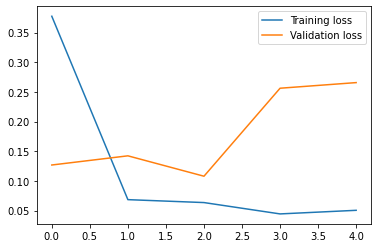

[Timestamp('2022-05-09 00:00:00', freq='D'), Timestamp('2022-05-10 00:00:00', freq='D'), Timestamp('2022-05-11 00:00:00', freq='D'), Timestamp('2022-05-12 00:00:00', freq='D'), Timestamp('2022-05-13 00:00:00', freq='D'), Timestamp('2022-05-14 00:00:00', freq='D'), Timestamp('2022-05-15 00:00:00', freq='D'), Timestamp('2022-05-16 00:00:00', freq='D'), Timestamp('2022-05-17 00:00:00', freq='D'), Timestamp('2022-05-18 00:00:00', freq='D'), Timestamp('2022-05-19 00:00:00', freq='D'), Timestamp('2022-05-20 00:00:00', freq='D'), Timestamp('2022-05-21 00:00:00', freq='D'), Timestamp('2022-05-22 00:00:00', freq='D'), Timestamp('2022-05-23 00:00:00', freq='D')]


/var/folders/yr/smlj2v7135v6h7n15bgx873h0000gn/T/ipykernel_94674/3136277444.py:72: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  original = df[f'Close_price_{stock}'].loc["2022-01-01":]


,Date,stock_price_NEE
0,2022-05-09,51.196655
1,2022-05-10,51.592022
2,2022-05-11,52.031986
3,2022-05-12,52.531532
4,2022-05-13,53.006176
5,2022-05-14,53.477993
6,2022-05-15,53.888554
7,2022-05-16,54.316761
8,2022-05-17,54.671024
9,2022-05-18,54.984322


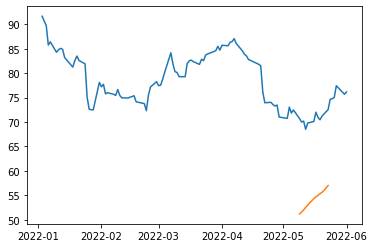

In [18]:
lstm_combined_dataset("NEE")

### Some ideas of the LSTM is from:

https://medium.com/mlearning-ai/multivariate-time-series-forecasting-using-rnn-lstm-8d840f3f9aa7


In [80]:
def lstm_combined_dataset_2(stock):
    steps = int(input("How many timesteps do you wish to use?: "))
    df = combined_stock_dataset(stock)
    target = df[f"Close_price_{stock}"].values
    X_train, X_test, y_train, y_test = df.iloc[-round(len(df)*0.8):], df.iloc[:-round(len(df)*0.8)],df.iloc[-round(len(df)*0.8):][f"Close_price_{stock}"], df.iloc[:-round(len(df)*0.8)][f"Close_price_{stock}"]
    X_train, X_test, y_train, y_test = X_train.values, X_test.values, y_train.values, y_test.values
    
    # scale data x
    sc = StandardScaler()
    X_train_scaled = sc.fit_transform(X_train)
    #scale y
    sc2 = StandardScaler()
    y_train_scaled = sc2.fit_transform(y_train.reshape(-1, 1))
    
    y_test = y_test.reshape(-1, 1)
    
    samples = X_train_scaled.shape[0]
    features = X_train_scaled.shape[1]
    # shaping training and testing sets 
    X_train1 = []
    y_train1 = []
    
    for i in range(steps,samples):
        X_train1.append(X_train_scaled[i-steps: i])
        y_train1.append(y_train_scaled[i])
    
    X_train1, y_train1 = np.array(X_train1), np.array(y_train1)
    #print(X_train1.shape)
    #print(y_train1.shape)
    
    # creating model
    model = Sequential()
    model.add(LSTM(64, activation='relu', input_shape = (X_train1.shape[1], X_train1.shape[2]), return_sequences=True))
    model.add(LSTM(32, activation='relu', return_sequences = False))
    model.add(Dropout(0.2))
    model.add(Dense(y_train1.shape[1]))

    model.compile(optimizer='adam', loss='mse')
    print(model.summary())
    
    model.fit(X_train1, y_train1, batch_size = 2, epochs=10)
    
    # for test data
    samples = X_test.shape[0]
    features = X_test.shape[1]
    
    X_test1 = []
    y_test1 = []
    for i in range(steps, samples):
        X_test1.append(X_test[i - steps : i])
        y_test1.append(y_test[i])
    X_test1, y_test1 = np.array(X_test1), np.array(y_test1)
    

    y_pred = model.predict(X_test1)
    y_pred = sc2.inverse_transform(y_pred)
    
    rmse = np.sqrt(np.mean(((y_pred - y_test1) ** 2)))
    print(rmse)
    
    train = df[-round(len(df)*0.8):]
    valid = df.iloc[:-round(len(df)*0.8)-steps]
    valid['Predictions'] = y_pred
    plt.figure(figsize=(16,6))
    plt.title('stock Model')
    plt.xlabel('Date', fontsize=18)
    plt.ylabel('Close Price USD ($)', fontsize=18)
    plt.plot(train[f'Close_price_{stock}'])
    plt.plot(valid[[f'Close_price_{stock}', 'Predictions']])
    plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
    plt.show()
    print(f"the rmse for {stock} is {rmse}")

    
    
    
    

How many timesteps do you wish to use?: 7


/var/folders/yr/smlj2v7135v6h7n15bgx873h0000gn/T/ipykernel_94674/180016135.py:18: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  oil_prices = oil_prices.loc["2020-01-01":]


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_16 (LSTM)              (None, 7, 64)             17664     
                                                                 
 lstm_17 (LSTM)              (None, 32)                12416     
                                                                 
 dropout_7 (Dropout)         (None, 32)                0         
                                                                 
 dense_9 (Dense)             (None, 1)                 33        
                                                                 
Total params: 30,113
Trainable params: 30,113
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
236/236 [==============================] - 3s 6ms/step - loss: 0.1844
Epoch 2/10
236/236 [==============================] - 1s 5ms/step - loss: 0.0603
Epoch 3/10
236/

/var/folders/yr/smlj2v7135v6h7n15bgx873h0000gn/T/ipykernel_94674/4192375416.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = y_pred


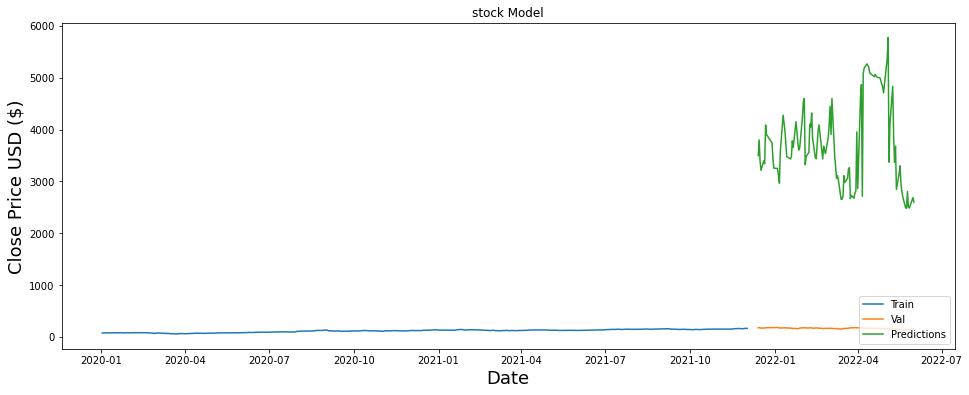

the rmse for AAPL is 3638.7867827888244


(472, 7, 4)

In [82]:
lstm_combined_dataset_2("AAPL")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


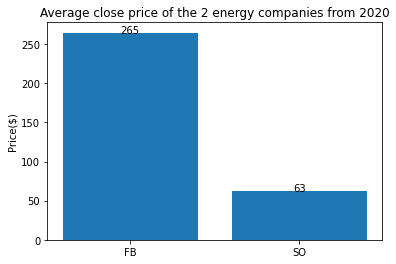

In [90]:
plot_mean_average_close_price("FB","SO")

In [12]:
type([1,2])

list